# DGA Detection
## Experiment 1
<p id="intro" style="color: green">This is a step-by-step guide on how to detect domains that were generated using "Domain Generation Algorithm" (DGA).<br>
The experiments are based on Applied Data Science for Security Professionals and <a href="https://github.com/osunjio/applied_data_science_sidi" target="_blank">Sidi Trainings (November 18th, 2020)</a> presented by <a href="https://www.gtkcyber.com/" target="_blank">GTK Cyber</a>.<br><br>
By transforming raw domain strings to Machine Learning features and creating a DGA classifer we determine whether a given domain is legit or not. Once we have implemented the classifier, the we can evaluate the model. Overview 2 main steps:
<ul style="color: green">
<li>Data Processing - exploration and data cleaning</li>
<li>Feature Engineering - from raw domain strings to numeric features using DataFrame manipulations. Then we introduce new features by transforming existing features</li>
<li>Machine Learning Classification - predict whether a domain is legit or not using a different classifiers</li>
</ul> 
</p>
<b><p style="color: green">
For this first experiment I use the dataset named 'dga_data_small.csv' which contains 2000 rows in comparison with the full dataset that contains 160003 rows (covered in Experiment 3 and 4).
</p></b>

<a href="#WorkingOn">Go back</a>

In [15]:
# Load libraries 
import pandas as pd
import numpy as np
import regex as re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.features import RadViz
from yellowbrick.features import Rank2D

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from pickle import dump
from pickle import load

<b><h3>Part 1 - Data Preprocessing</h3></b>

In [16]:
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/dga_data_small.csv')
df.head()

,isDGA,domain,host,subclass
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga
2,dga,thenrest,thenrest.net,nivdort
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga


In [17]:
df.shape

(2000, 4)

In [18]:
missing_values = df.isnull().sum()
missing_values

isDGA       0
domain      0
host        0
subclass    0
dtype: int64

In [19]:
df = df.drop_duplicates()
df = df.reset_index(inplace=False, drop=True)
df.shape

(2000, 4)

In [20]:
print(f"DGA: {df['isDGA'].value_counts()['dga']}")
print(f"Legit: {df['isDGA'].value_counts()['legit']}")

DGA: 1000
Legit: 1000


In [21]:
df['subclass'].value_counts()

subclass
alexa           501
legit           499
cryptolocker    462
newgoz          119
necurs          111
nivdort         108
gameoverdga     105
goz              77
bamital          18
Name: count, dtype: int64

<b><h3>Part 2 - Feature Engineering</h3></b>

For the feature engineering process I manually hand-craft useful contextual information of the domain string. An alternative approach (not covered in this notebook) is "Featureless Deep Learning", where an embedding layer takes care of deriving features (step towards more "AI" oriented approach that will be covered in other experiment). I will focus on the following features that are based on contextual information:
<ol>
<li>Length ["length"]</li>
<li>Number of digits ["digits"]</li>
<li>Entropy ["entropy"] - use H_entropy function provided</li>
<li>Vowel to consonant ratio ["vowel-cons"] - use vowel_consonant_ratio function provided</li>
<li>The index of the first digit - use the firstDigitIndex function provided</li>
<li>N-grams ["n-grams"] - use ngram functions provided</li>
</ol>>

In [22]:
df.drop(['host', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.head()

(2000, 2)


,isDGA,domain
0,dga,tyopcrkqgxcfm
1,dga,72j5rn1l9mzleo6203v1ogenfl
2,dga,thenrest
3,dga,15ihbm71utcnfa8dk1mmgoobl9
4,dga,x1d6ou7e7kofk60ayhq74x7e


<p><a href="https://books.google.com/ngrams/info" target="_blank">Google Ngram Viewer</a>: While not specifically a list, Google's Ngram Viewer allows us to search for the frequency of words or phrases in a vast corpus of books over time, which can give us an idea of common words. Google's list of most common English words is not publicly available in real-time.</p>
This <a href="https://github.com/first20hours/google-10000-english">repo</a> contains a list of the 10,000 most common English words in order of frequency, as determined by <a href="https://en.wikipedia.org/wiki/Frequency_analysis">n-gram frequency analysis</a> of the Google's Trillion Word Corpus. 
</br>

In [23]:
# Google's 10000 most common english words [1] will be used to derive a feature called ngram. This feature will be used to detect DGA domains
top_english_words = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/google-10000-english.txt', header=None, names=['words'])
print(top_english_words.head())
d = top_english_words
# Save as pickle file
dump(d, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'wb'))

  words
0   the
1    of
2   and
3    to
4     a


In [25]:
# Function to calculate Shannon Entropy
def H_entropy(domain):    
    prob = [ float(domain.count(c)) / len(domain) for c in dict.fromkeys(list(domain)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

# Function to get the index of the first digit of a given domain
def firstDigitIndex(domain):
    for i, c in enumerate(domain):
        if c.isdigit():
            return i + 1
    return 0

# Function to calculate number of digits 
def numDigits(domain):
    return sum(c.isdigit() for c in domain)

# Function to calculate vowel to consonant ratio
def vowel_consonant_ratio(domain):    
    domain = domain.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, domain)
    consonants = re.findall(consonants_pattern, domain)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

In [26]:
# Transform IsDGA to binary values
df['isDGA'] = df['isDGA'].apply(lambda x: 1 if x == 'dga' else 0)
df.head()

,isDGA,domain
0,1,tyopcrkqgxcfm
1,1,72j5rn1l9mzleo6203v1ogenfl
2,1,thenrest
3,1,15ihbm71utcnfa8dk1mmgoobl9
4,1,x1d6ou7e7kofk60ayhq74x7e


In [27]:
# Extract features from the domain (derive new features)
df['length'] = df['domain'].apply(lambda x: len(x))
df['digits'] = df['domain'].apply(lambda x: numDigits(x))
df['entropy'] = df['domain'].apply(lambda x: H_entropy(x))
df['vowel_cons'] = df['domain'].apply(lambda x: vowel_consonant_ratio(x))
df['firstDigitIndex'] = df['domain'].apply(lambda x: firstDigitIndex(x))
df.head()

,isDGA,domain,length,digits,entropy,vowel_cons,firstDigitIndex
0,1,tyopcrkqgxcfm,13,0,3.546594,0.083333,0
1,1,72j5rn1l9mzleo6203v1ogenfl,26,10,4.132944,0.333333,1
2,1,thenrest,8,0,2.500000,0.333333,0
3,1,15ihbm71utcnfa8dk1mmgoobl9,26,7,4.180833,0.357143,1
4,1,x1d6ou7e7kofk60ayhq74x7e,24,9,3.834963,0.666667,2


<div class="alert alert-block alert-danger">
<b>Important:</b> Below we should see the result of running the code from the original <a href="https://github.com/osunjio/applied_data_science_sidi/blob/78e6da047845d071667bb887e28a5c120c8e6a12/notebooks/Worksheet%204%20-%20Feature%20Engineering.ipynb" target="_blank">Github repository</a></span></b>, meaning after having applied the ngrams functions,added ngrams as a new feature in the dataset original dataset "df" and having dropped the 'domain' column. Because I got stuck and couldn't fix the errors, I had to use the processed dataset "dga_features_final_df.csv".
</div>

In [28]:
# Here we use the dga_features_final_df.csv file which already dropped the 'domain' column
df_final = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/processed/dga_features_final_df.csv')
print(df_final.shape)
print(df_final['isDGA'].value_counts())

(2000, 7)
isDGA
1    1000
0    1000
Name: count, dtype: int64


In [30]:
df_final.head()

,isDGA,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
0,1,13,0,3.546594,0.083333,0,744.670940
1,1,26,10,4.132944,0.333333,1,715.217265
2,1,8,0,2.500000,0.333333,0,1918.797619
3,1,26,7,4.180833,0.357143,1,682.269402
4,1,24,9,3.834963,0.666667,2,544.178140


<b><h3>Part 3 - Data Visualization</h3></b>

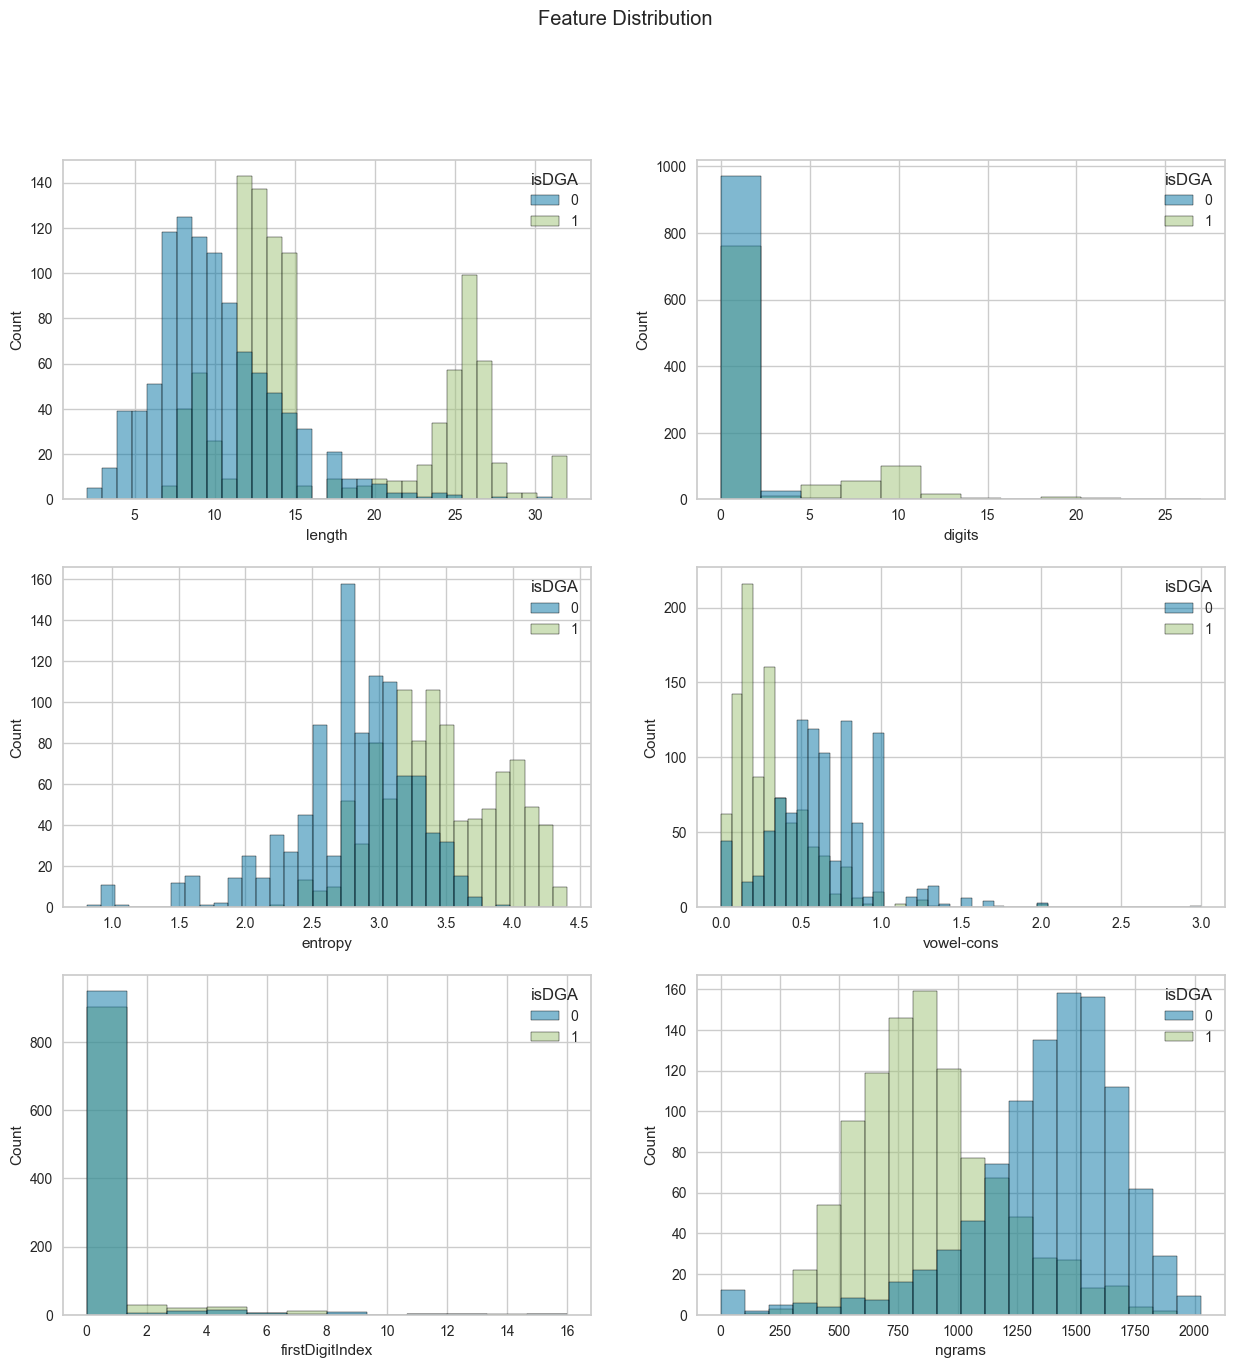

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Feature Distribution')

sns.histplot(data=df_final, x='length', hue='isDGA', ax=axes[0, 0])
sns.histplot(data=df_final, x='digits', hue='isDGA', ax=axes[0, 1])
sns.histplot(data=df_final, x='entropy', hue='isDGA', ax=axes[1, 0])
sns.histplot(data=df_final, x='vowel-cons', hue='isDGA', ax=axes[1, 1])
sns.histplot(data=df_final, x='firstDigitIndex', hue='isDGA', ax=axes[2, 0])
sns.histplot(data=df_final, x='ngrams', hue='isDGA', ax=axes[2, 1])

plt.show()

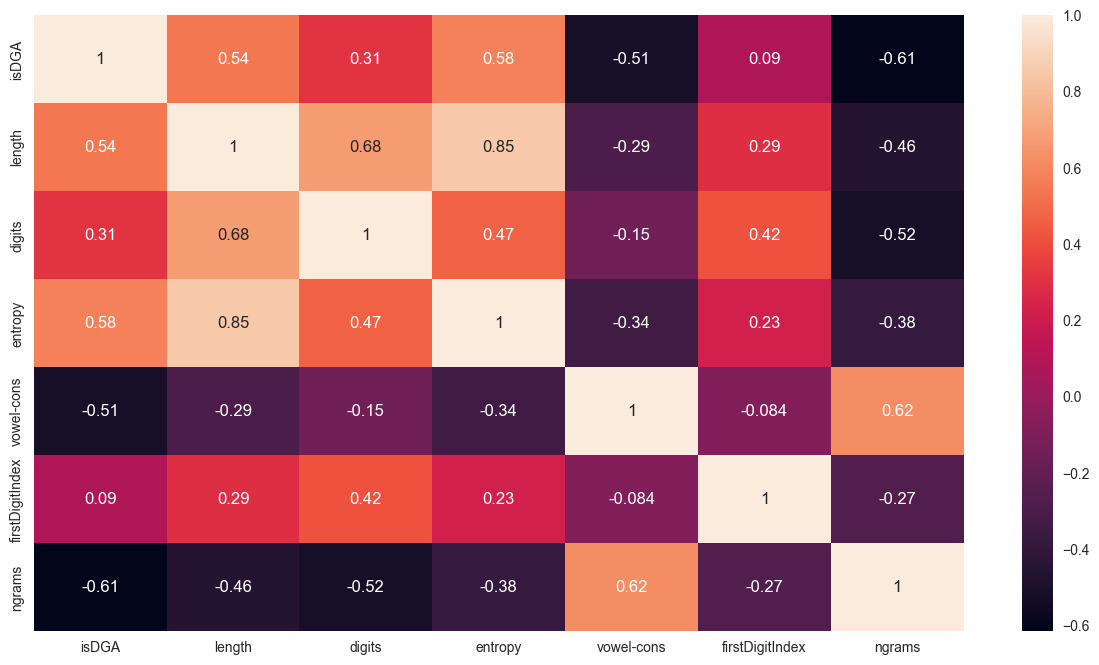

In [32]:
# Correalation matrix
corr = df_final.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True)   
plt.show()

<div class="alert alert-block alert-success">
From the correlation matrix we can see that the ngrams feature has a high correlation with the target variable along with the entropy feature and the length feature. We can see that the ngrams feature has a high correlation with the target variable along with the entropy feature and the length feature. Now we are going to use the ngrams feature to build a model to predict DGA domains.
</div>

<b><h3>Part 4 - Training the Decision Tree Classifier model</h3></b>

In [35]:
X = df_final[['ngrams', 'entropy', 'length']]
y = df_final['isDGA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [36]:
y_pred = dt_clf.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.50%


In [53]:
dump(dt_clf, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr1_dt_clf_42.pkl', 'wb'))

In [39]:
hyperparameters = {'criterion': ['gini', 'entropy', 'log_loss'], 
                     'max_depth': [None, 5, 15, 20, 25], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5]} 

dt_clf_grid = GridSearchCV(dt_clf, hyperparameters, scoring='accuracy', cv=10) 
dt_clf_grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='accuracy')

In [40]:
dt_clf_grid.fit(X_train, y_train) 
print(f"Best hyperparameters: {dt_clf_grid.best_params_}") 

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 20}


In [42]:
dt_clf_optimized = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=4, min_samples_split=20, random_state=42)
dt_clf_optimized.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=20,
                       random_state=42)

In [43]:
y_pred_opt = dt_clf_optimized.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_opt)
print(f"Accuracy: %.2f%%" % (accuracy_optimized * 100.0))

Accuracy: 91.50%


In [54]:
dump(dt_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr1_dt_clf_42_gini_maxdp-5_minsmpl-4_minsmpp-20.pkl', 'wb'))

<b><h3>Part 5 - Training other classifiers</h3></b>
<h4>Random Forest Classifier</h4>

In [45]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [46]:
y_pred_rf = rf_clf.predict(X_test)

In [47]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: %.2f%%" % (accuracy_rf * 100.0))

Accuracy: 89.00%


In [55]:
dump(rf_clf, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr1_rf_clf_42.pkl', 'wb'))

In [48]:
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                     'criterion': ['gini', 'entropy', 'log_loss'], 
                     'max_depth': [None, 5, 15, 20, 25], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5]} 

rf_clf_grid = GridSearchCV(rf_clf, hyperparameters, cv=10) 
rf_clf_grid

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150, 200]})

In [ ]:
rf_clf_grid.fit(X_train, y_train) 
print(f"Best hyperparameters: {rf_clf_grid.best_params_}") 

In [50]:
rf_clf_optimized = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10, min_samples_leaf=5, min_samples_split=20, random_state=42)
rf_clf_optimized.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=20, random_state=42)

In [51]:
y_pred_rf_opt = rf_clf_optimized.predict(X_test)
accuracy_rf_optimized = accuracy_score(y_test, y_pred_rf_opt)
print(f"Accuracy: %.2f%%" % (accuracy_rf_optimized * 100.0))

Accuracy: 92.00%


In [52]:
dump(rf_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr1_rf_clf_42_nest-100_maxdp-10_minsmpl-5_minsmpp-20.pkl', 'wb')) 

<h4>K-NN Classifier</h4>

In [56]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [57]:
y_pred_knn = knn_clf.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: %.2f%%" % (accuracy_knn * 100.0))

Accuracy: 86.50%


In [58]:
hyperparameters = {'n_neighbors': [3, 5, 7, 9, 11], 
                   'weights': ['uniform', 'distance'], 
                   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                   'leaf_size': [10, 20, 30, 40, 50], 
                   'p': [1, 2]} 

knn_clf_rand_search = RandomizedSearchCV(knn_clf, hyperparameters, cv=10, n_iter=10, random_state=42)
knn_clf_rand_search

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30, 40, 50],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [201]:
# train model with randomized search
knn_clf_rand_search.fit(X_train, y_train) # Fit the randomized search model to the training data.
print(f"Best hyperparameters: {knn_clf_rand_search.best_params_}") # Print the best parameters

Best hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'leaf_size': 10, 'algorithm': 'kd_tree'}


In [59]:
knn_clf_optimized = KNeighborsClassifier(n_neighbors=7, weights='distance', leaf_size=10, p=1, algorithm='kd_tree') 
knn_clf_optimized.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=7, p=1,
                     weights='distance')

In [60]:
y_pred_knn_opt = knn_clf_optimized.predict(X_test)
accuracy_knn_optimized = accuracy_score(y_test, y_pred_knn_opt)
print(f"Accuracy: %.2f%%" % (accuracy_knn_optimized * 100.0))

Accuracy: 88.75%


In [61]:
# Save the model
dump(knn_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr1_knn_clf_42_nneigh-7_weights-dist_leafsize-10_p-1_algo-kd_tree.pkl', 'wb'))

<h4>Boosting Algorithms</h4>

In [62]:
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [63]:
y_pred_xgb = xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy: %.2f%%" % (accuracy_xgb * 100.0))

Accuracy: 89.50%


In [64]:
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                   'max_depth': [3, 5, 7, 9, 11], 
                   'learning_rate': [0.01, 0.1, 0.2, 0.3], 
                   'subsample': [0.5, 0.7, 0.9], 
                   'colsample_bytree': [0.5, 0.7, 0.9], 
                   'gamma': [0, 1, 5]}

xgb_clf_rand_search = RandomizedSearchCV(xgb_clf, hyperparameters, cv=10, n_iter=10, random_state=42) 
xgb_clf_rand_search

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.5, 0.7, 0.9]},
                   random_state=42)

In [211]:
xgb_clf_rand_search.fit(X_train, y_train) # Fit the randomized search model to the training data.
print(f"Best hyperparameters: {xgb_clf_rand_search.best_params_}") # Print the best parameters

Best hyperparameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.7}


In [65]:
xgb_clf_optimized = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.7, colsample_bytree=0.7, gamma=50, random_state=42)
xgb_clf_optimized.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=50, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [66]:
y_pred_xgb_opt = xgb_clf_optimized.predict(X_test)
accuracy_xgb_optimized = accuracy_score(y_test, y_pred_xgb_opt)
print(f"Accuracy: %.2f%%" % (accuracy_xgb_optimized * 100.0))

Accuracy: 92.75%


In [68]:
dump(xgb_clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr1_xgb_clf_42_nest-200_maxdp-7_lr-0.1_subsample-0.7_colsample-0.7_gamma-50.pkl', 'wb'))

<h3>First experiment results</h3>

<table class="demo">
<thead>
    <tr>
        <th>Model</th>
        <th>Accuracy</th>
        <th>Accuracy (optimized)</th>
    </tr>
</thead>
    <tbody>
    <tr>
        <td>DecisionTreeClassifier</td>
        <td>87.50%</td>
        <td>91.50%</td>
    </tr>
    <tr>
        <td>RandomForestClassifier</td>
        <td>89.00%</td>
        <td>92.00%</td>
    </tr>
    <tr>
        <td>KNeighborsClassifier</td>
        <td>86.50%</td>
        <td>88.75%</td>
    </tr>
    <tr>
        <td>XGBClassifier</td>
        <td>89.50%</td>
        <td>92.75%</td>
    </tr>
    </tbody>
</table>

<a id="WorkingOn" href="#intro">Go up</a>

### References
<ul>
    <li>Google Ngram Viewer, <a href="https://books.google.com/ngrams/info" target="_blank">link</a></li>
    <li>n-gram frequency analysis, <a href="https://en.wikipedia.org/wiki/Frequency_analysis">link</a></li>
    <li>Github repository of list of the 10,000 most common English words in order of frequency, <a href="https://github.com/first20hours/google-10000-english">link</a></li>
</ul>